In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from activation.acts import *


def vis_activations_with_derivates(acts, x, cols, xlim=None, ylim=None):
    """
    Visualizes the activations and their derivatives for a set of input data.
    
    Parameters:
    - acts: A dictionary with keys as the names of activation functions and values as instances of those functions.
    - x: The input tensor with `requires_grad=True`.
    - cols: The number of graphs to display per row.
    
    Example usage:
        acts = {
            'ReLU': nn.ReLU(),
            'SCiU_square': SCiU(pos_multiplier=1, neg_multiplier=1, clip_max=1, clip_min=-1),
            'SCiU_squarev2': SCiU(pos_multiplier=2, neg_multiplier=2, clip_max=1, clip_min=-1)
        }
        x = torch.linspace(-5, 5, 100, requires_grad=True)  # Example input tensor
        vis_activations(acts, x, cols=2)
    """
    total = len(acts)
    rows = total // cols + (1 if total % cols else 0)
    
    plt.figure(figsize=(cols * 10, rows * 4))  # Adjusting size for better visibility
    
    for i, (name, activation_instance) in enumerate(acts.items(), start=1):
        y = activation_instance(x)
        y.backward(torch.ones_like(x), retain_graph=True)
        
        # Plotting activation
        plt.subplot(rows, 2 * cols, 2 * i - 1)
        plt.plot(x.detach().numpy(), y.detach().numpy())
        plt.title(f'{name} Activation')
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
        
        # Plotting derivative
        plt.subplot(rows, 2 * cols, 2 * i)
        plt.plot(x.detach().numpy(), x.grad.detach().numpy())
        plt.title(f'{name} Derivative')
        x.grad.zero_()  # Clear gradients for the next calculation
        
        if xlim:
            plt.xlim(xlim)
        # No ylim for derivative to auto-adjust
        
    plt.tight_layout()
    plt.show()

In [2]:
class Identity(nn.Module):
    def forward(self, x):
        return x  # This is equivalent to 'lambda x: x'

In [3]:
# ./activation/acts.py
acts = get_activations(return_type='dict')
acts.update({
    # 'sASN_100_res18':sASN(alpha=0.1,beta_init=1.),
    # 'ASN_10_res18':ASN(alpha=0.1,beta_init=-6.7338),
    # 'sASN_10_res18':sASN(alpha=0.1,beta_init=5.9771),
    # 'sASN_100_swin':sASN(beta_init=0.3607) , 
    'ReLU':nn.ReLU(),
    # 'sSigmoid':sSigmoid(beta_init=1.),
    # 'GELU':nn.GELU(),
    # 'GELUa':GELUa(),
    'Identity':Identity(),
})
acts

{'sASN': sASN(),
 'ASN': ASN(),
 'GELU': GELU(approximate='none'),
 'ELU': ELU(alpha=1),
 'SiLU': SiLU(),
 'Swish': Swish(),
 'Mish': Mish(),
 'Softplus': Softplus(beta=1, threshold=20),
 'SoftModulusQ': SoftModulusQ(),
 'sSigmoid': sSigmoid(),
 'SwishTb': SwishTb(),
 'Twish': Twish(),
 'SliuT': SliuT(),
 'Modulus': Modulus(),
 'ReLU': ReLU(),
 'Identity': Identity()}

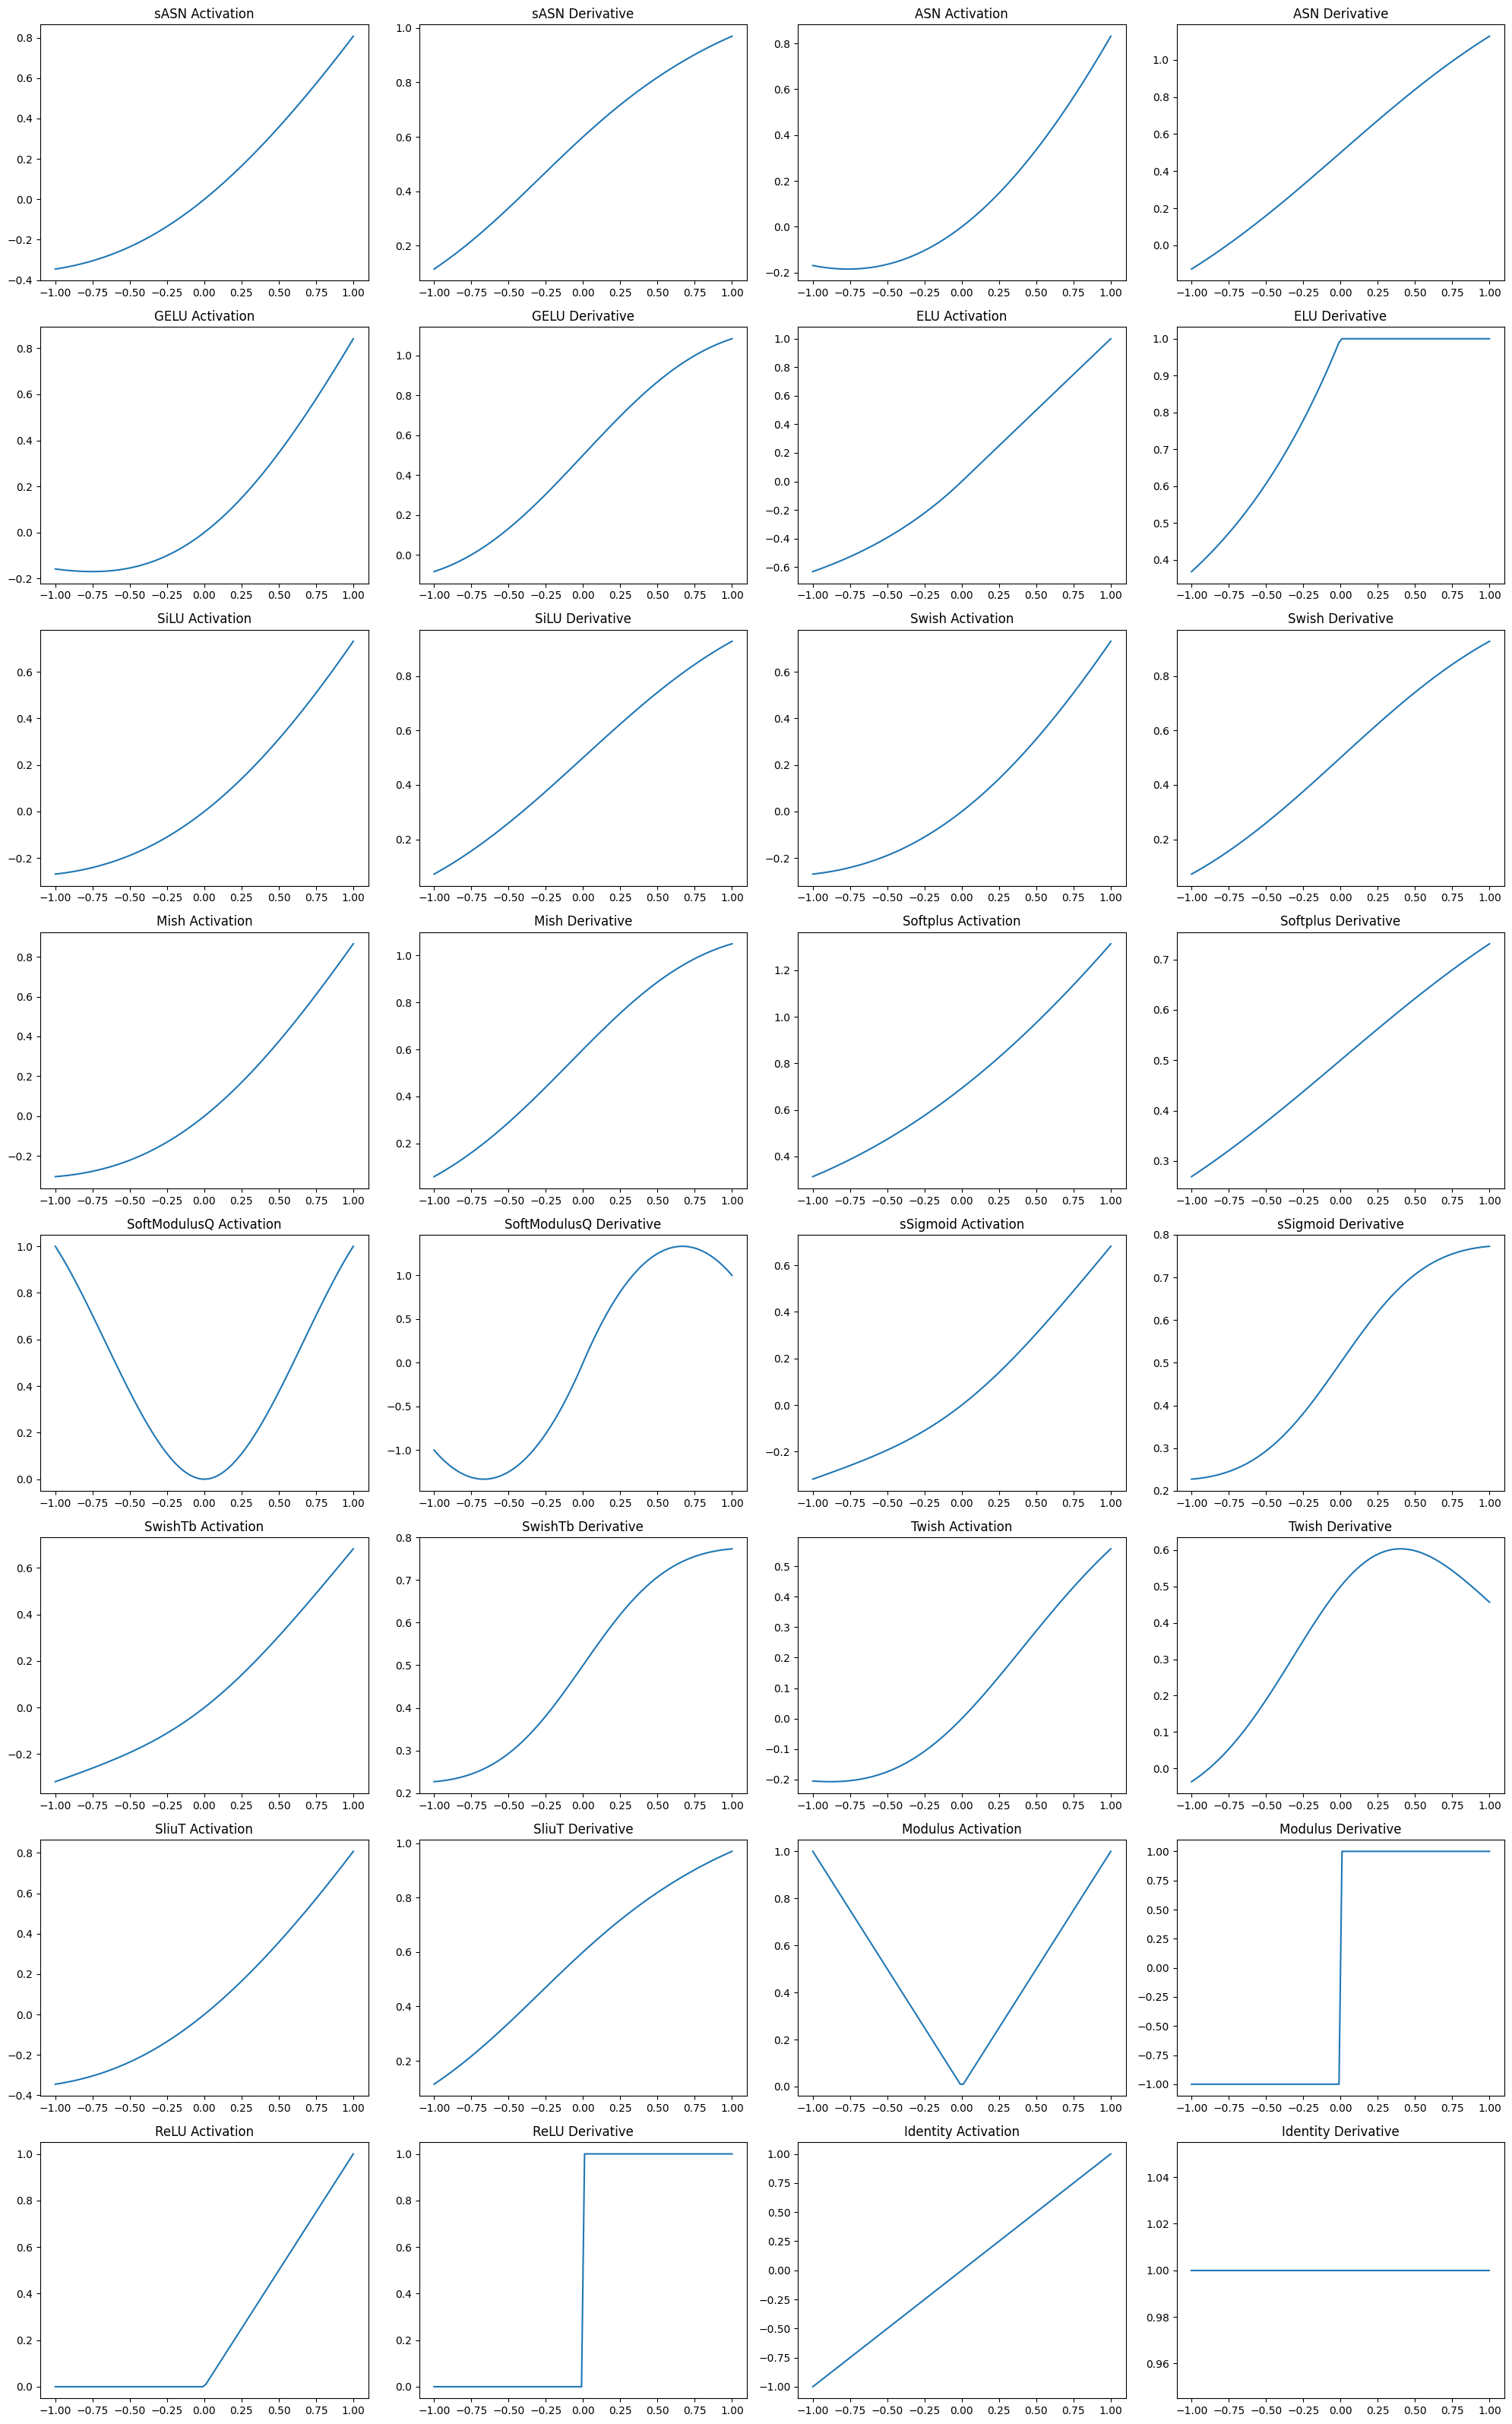

In [4]:
vis_activations_with_derivates(acts=acts,x=torch.linspace(-1, 1, 100, requires_grad=True),cols=2)

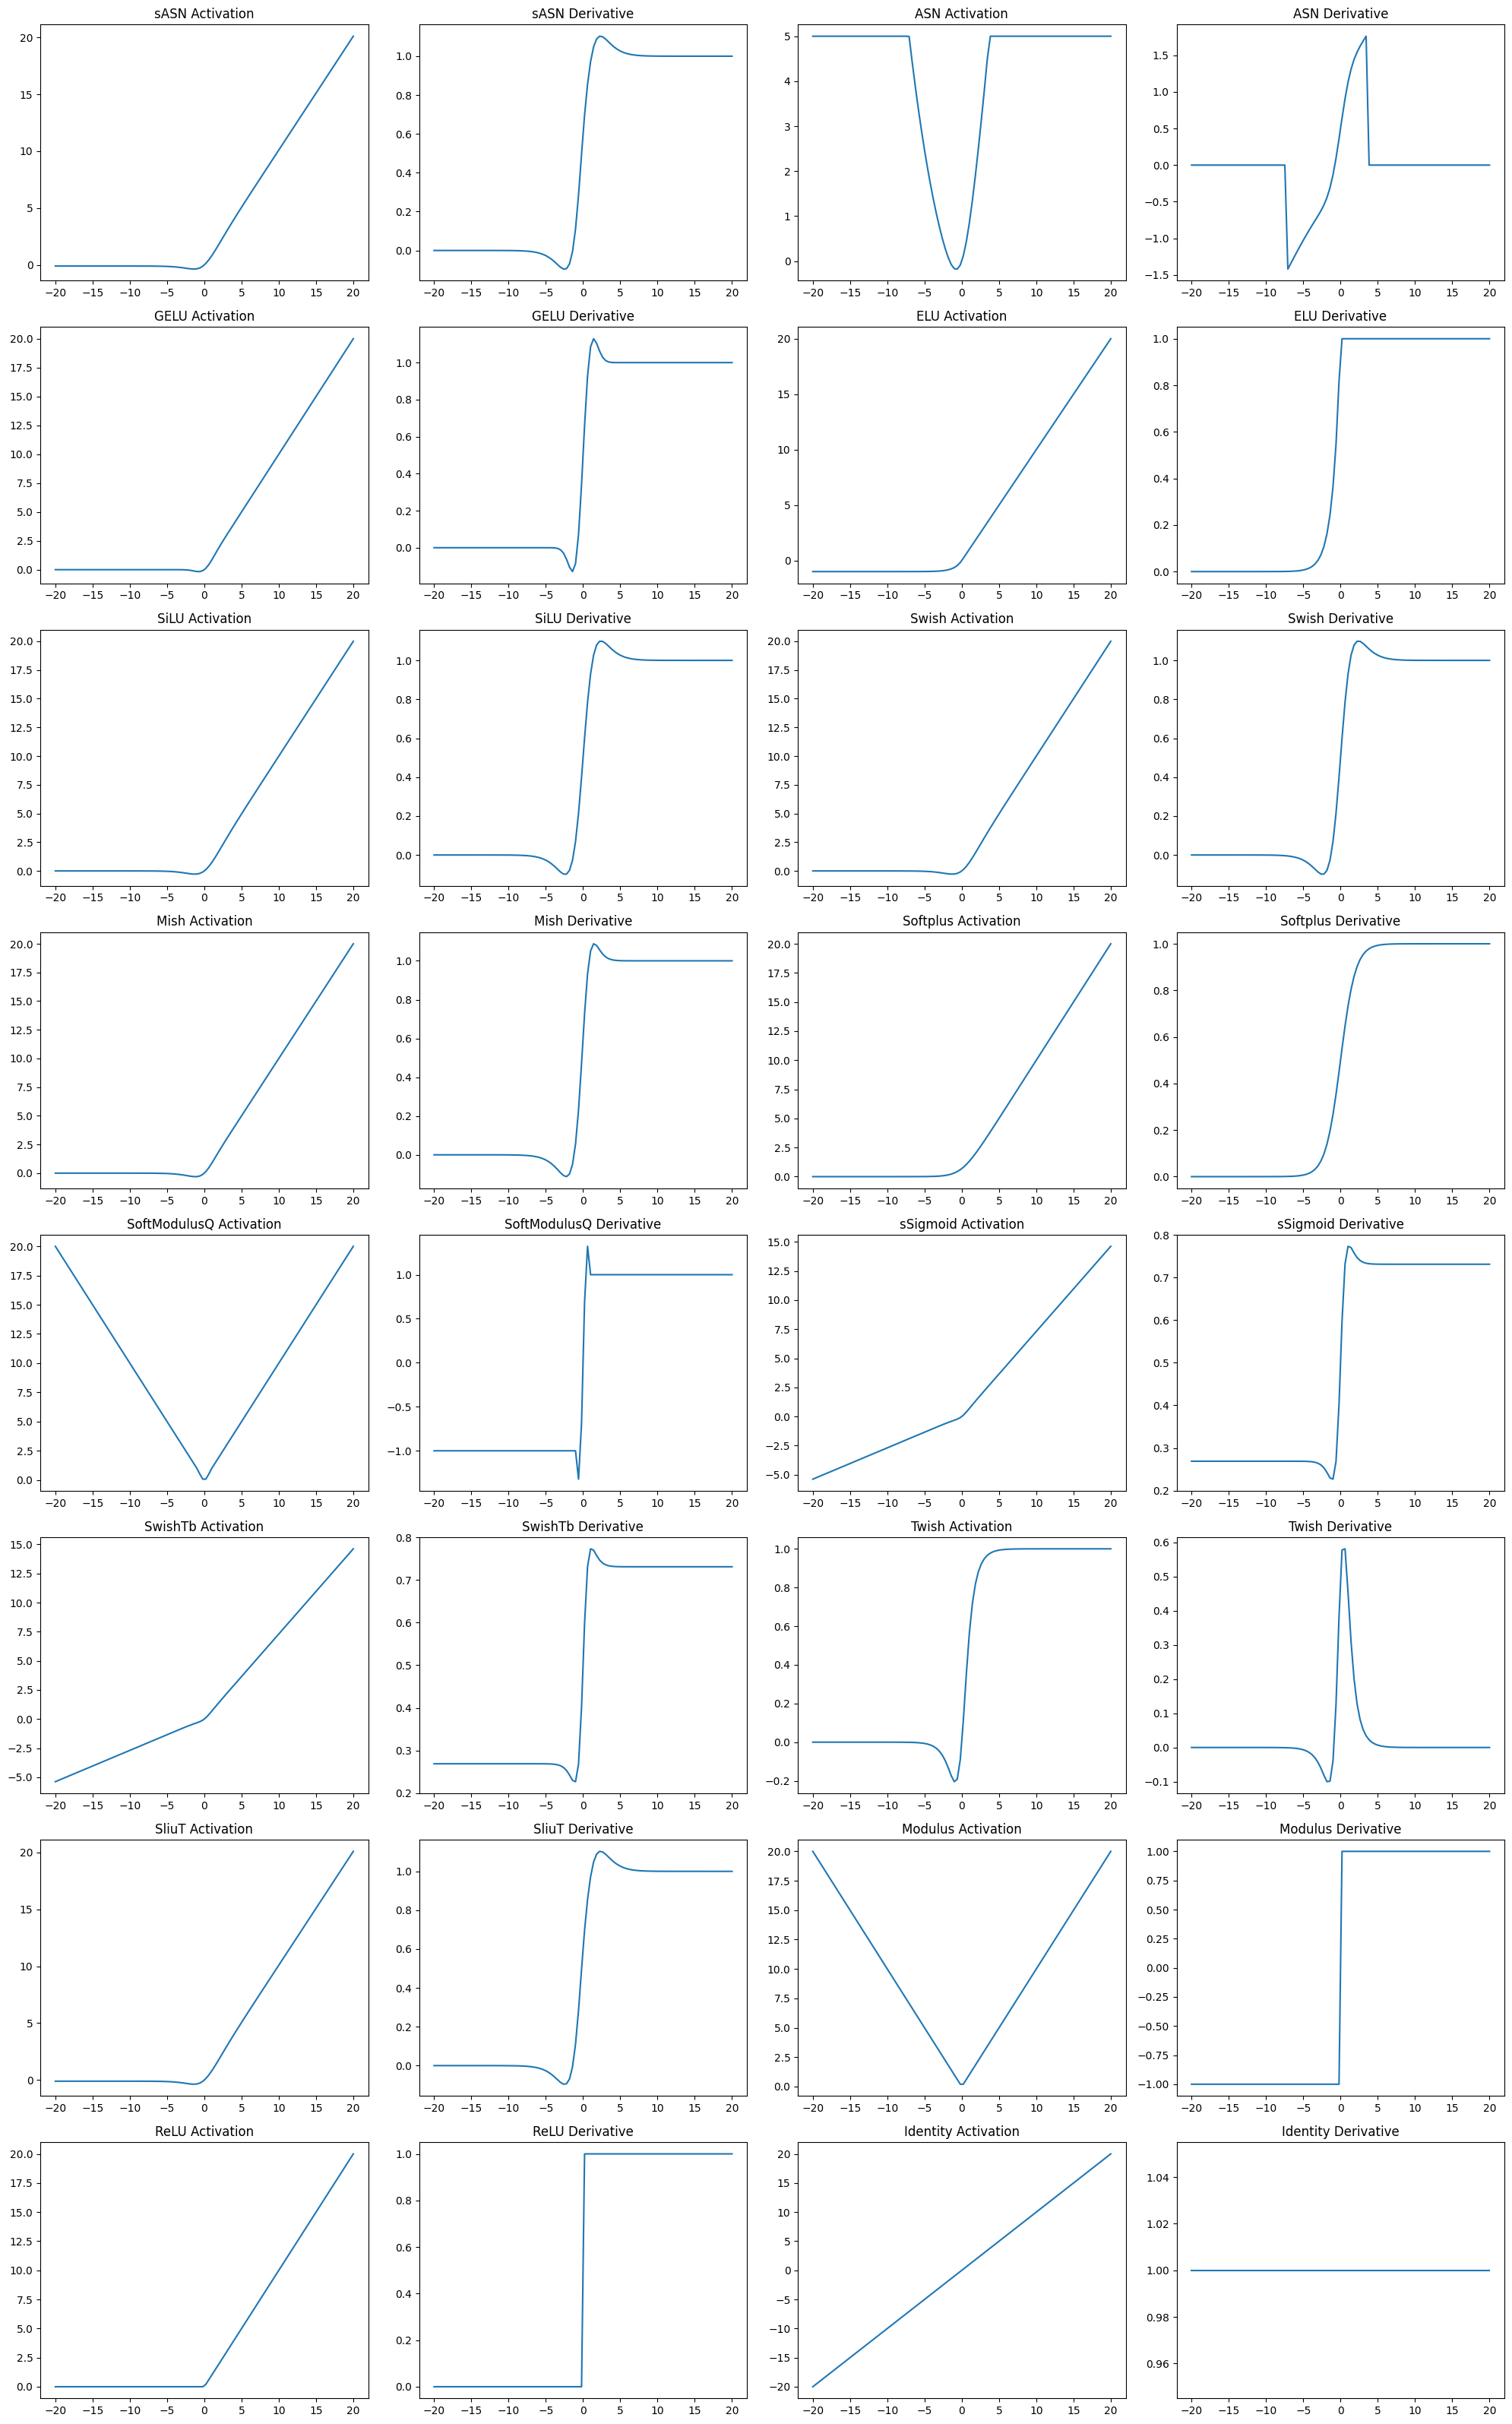

In [5]:
vis_activations_with_derivates(acts=acts,x=torch.linspace(-20, 20, 100, requires_grad=True),cols=2)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


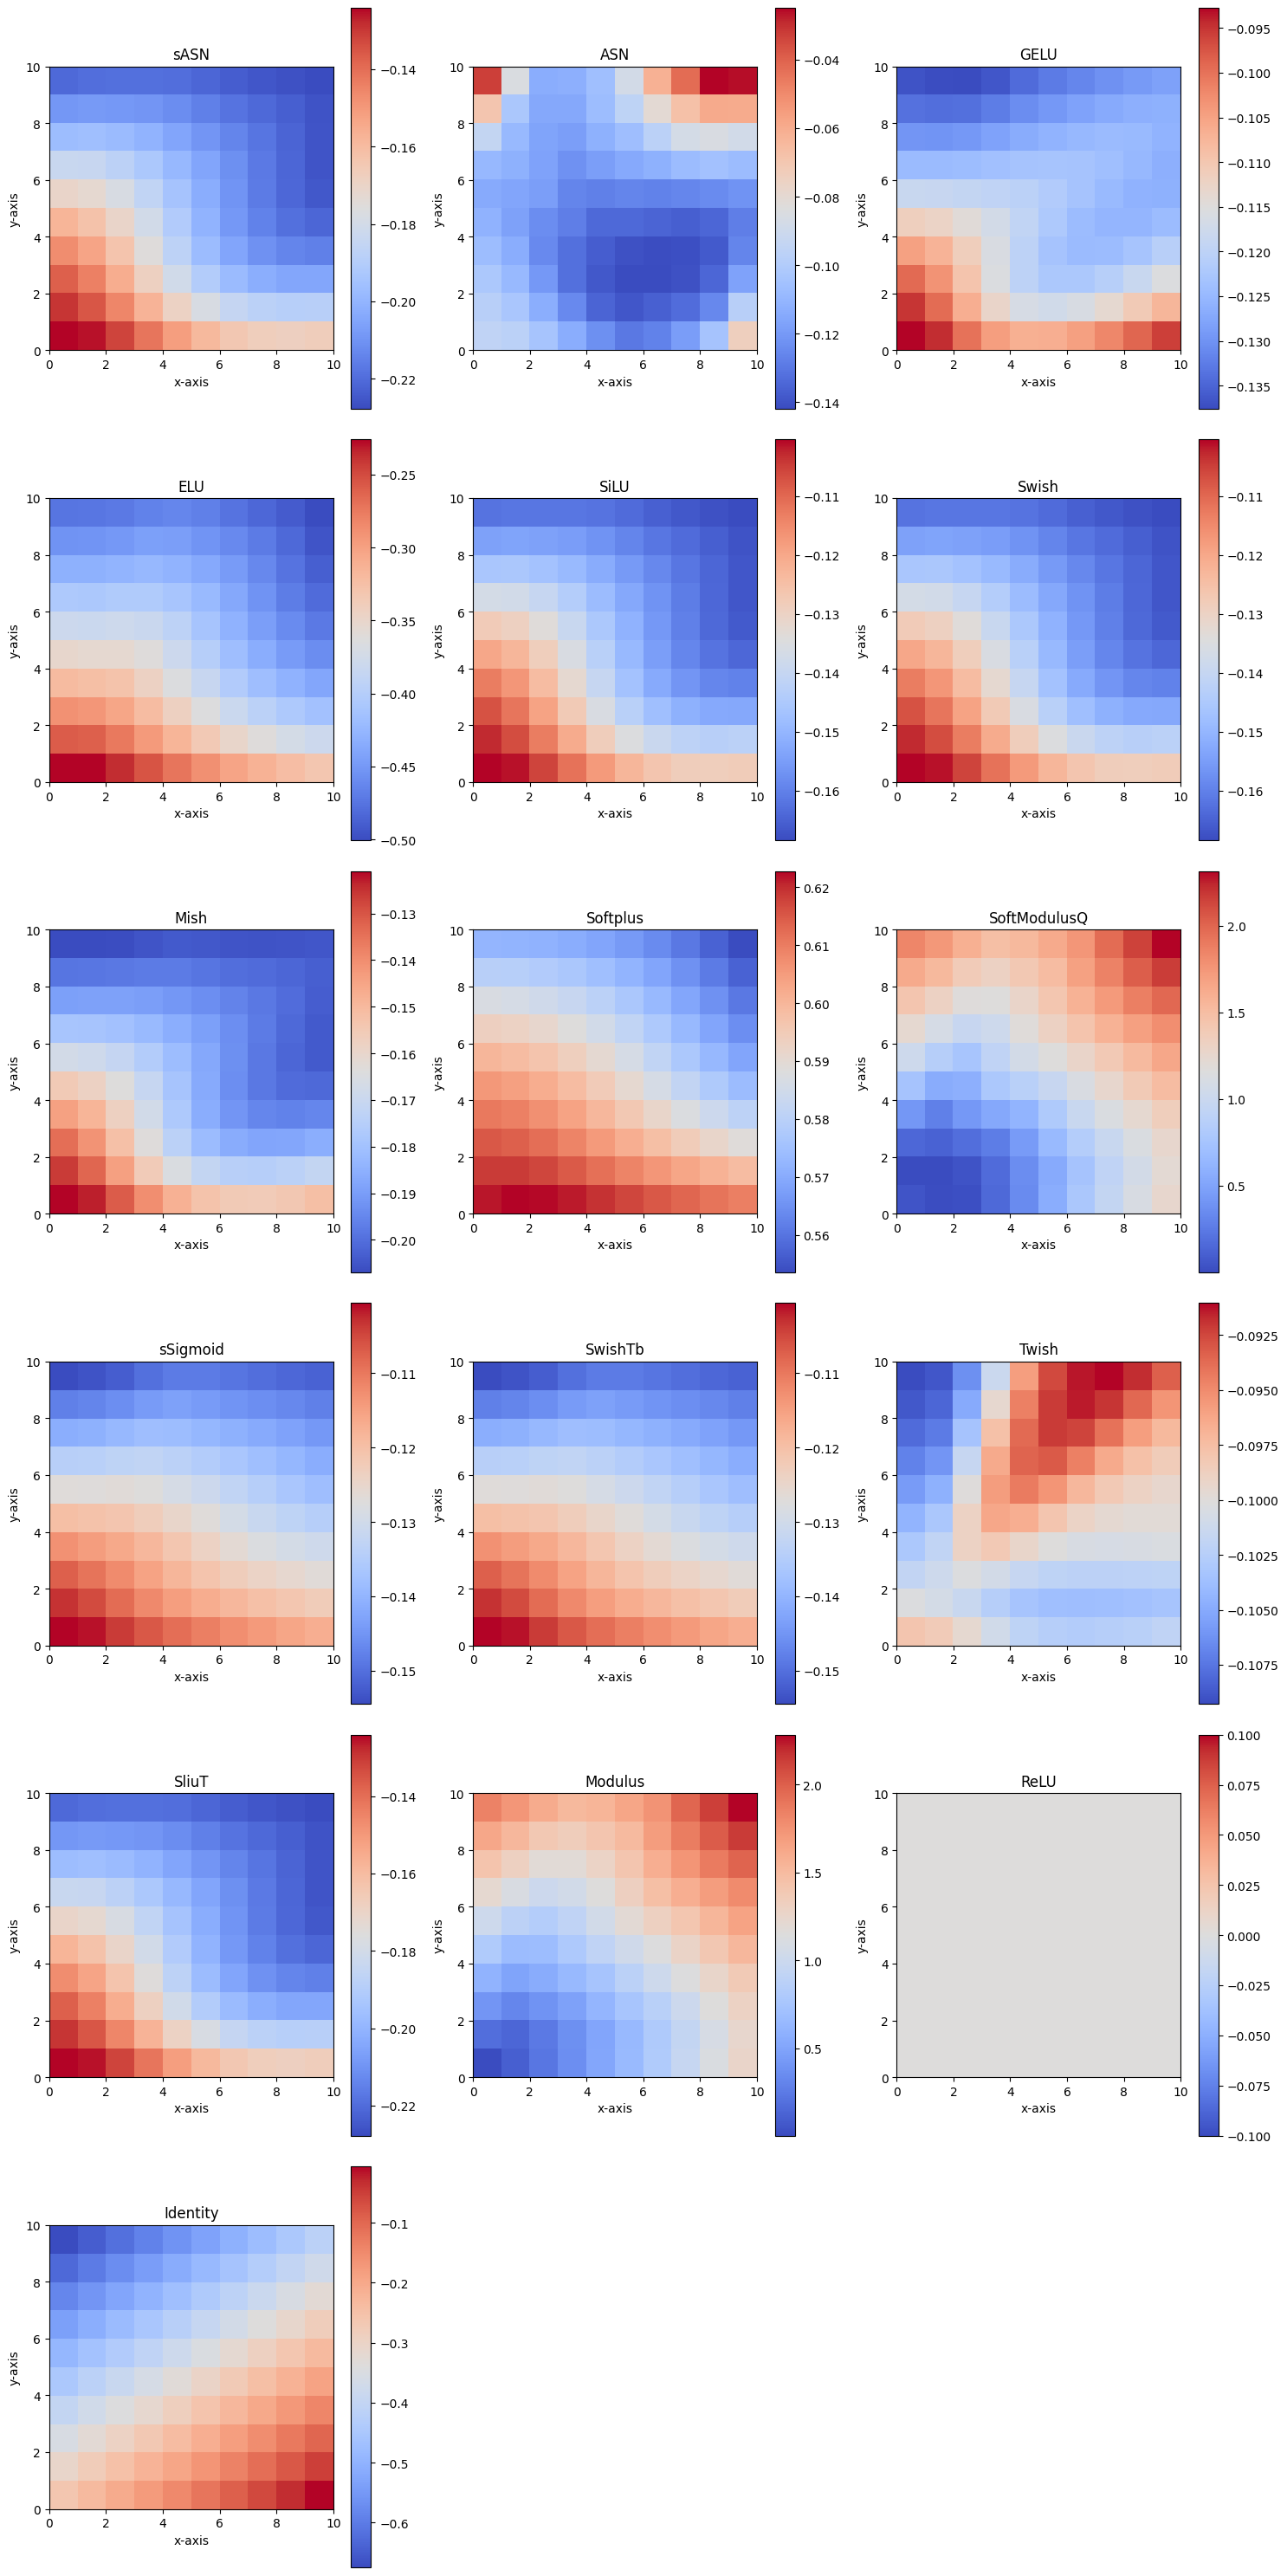

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, activation_func,bias=True,use_bn=False,use_ln=False):
        super(SimpleNN, self).__init__()
        self.activation_func = activation_func
        self.use_bn = use_bn
        # Define a dummy layer to simulate a neural network operation
        self.fc1 = nn.Linear(2, 64,bias=bias)
        self.bn1 = nn.BatchNorm1d(64) if not use_ln else nn.LayerNorm(64)
        self.fc2 = nn.Linear(64, 32,bias=bias)
        self.bn2 = nn.BatchNorm1d(32) if not use_ln else nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, 16,bias=bias)
        self.bn3 = nn.BatchNorm1d(16) if not use_ln else nn.LayerNorm(16)
        self.fc4 = nn.Linear(16, 1,bias=bias)
        self.bn4 = nn.BatchNorm1d(1) if not use_ln else nn.LayerNorm(1)

    def forward(self, x):
        x = self.activation_func(self.bn1(self.fc1(x)) if self.use_bn else self.fc1(x))  # Apply a linear transformation
        x = self.activation_func(self.bn2(self.fc2(x)) if self.use_bn else self.fc2(x))  # Apply a linear transformation
        x = self.activation_func(self.bn3(self.fc3(x)) if self.use_bn else self.fc3(x))  # Apply a linear transformation
        x = self.activation_func(self.bn4(self.fc4(x)) if self.use_bn else self.fc4(x))  # Apply a linear transformation
        return x

def plot_output_landscape(network, resolution=400):
    linspace = torch.linspace(0, 10, resolution)
    x, y = torch.meshgrid(linspace, linspace)
    grid = torch.stack((x.flatten(), y.flatten()), dim=1)

    with torch.no_grad():
        output = network(grid).reshape(resolution, resolution)
    return output

def visualize_activations(acts, resolution=400, cols=3,use_bn=False):
    rows = (len(acts) + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 5))
    network = SimpleNN(lambda x:x)
    for i, (name, activation_func) in enumerate(acts.items(), 1):
        plt.subplot(rows, cols, i)
        network.activation_func=activation_func
        output = plot_output_landscape(network, resolution)
        plt.imshow(output, extent=(0, 10, 0, 10), origin='lower', cmap='coolwarm')
        plt.colorbar()
        plt.title(name)
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
    plt.tight_layout()
    plt.show()


visualize_activations(acts, resolution=10, cols=3,use_bn=True)

/tmp/ipykernel_2870207/296814984.py:49: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


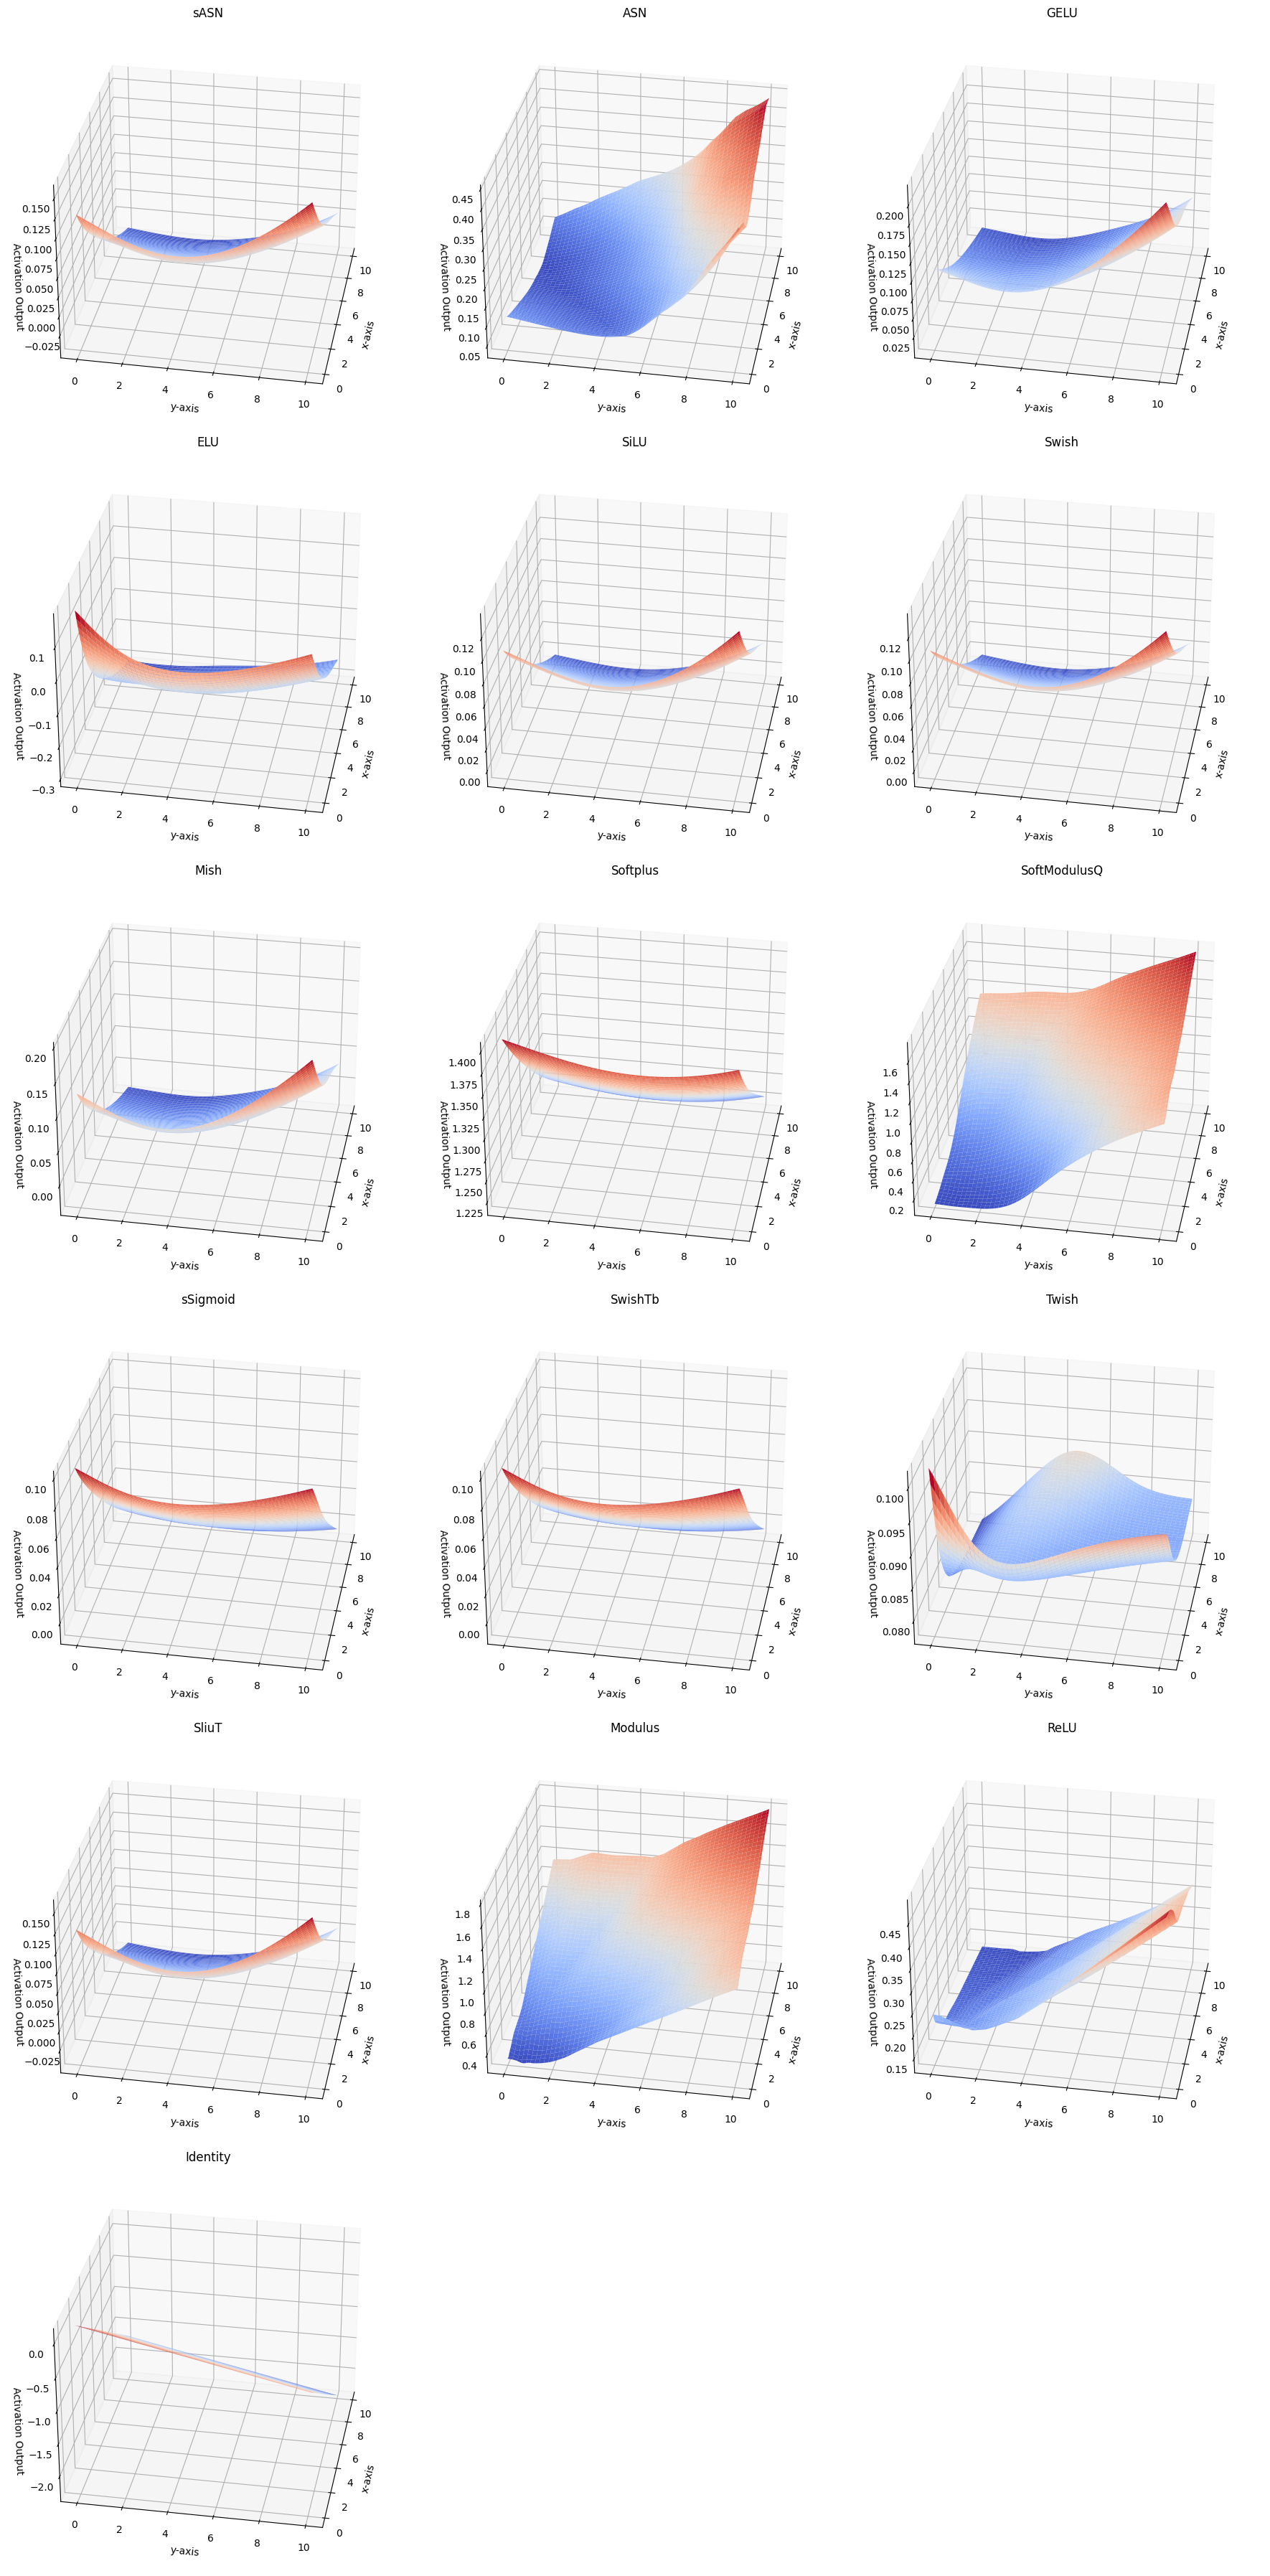

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming the rest of your code is defined above and the 'SimpleNN' class is available

def plot_3d_output_landscape(network, resolution=400, input_type='linspace', input_range=(0, 10)):
    # Generate input grid based on the specified input type
    if input_type == 'linspace':
        linspace = torch.linspace(*input_range, resolution)
    elif input_type == 'gaussian':
        linspace = torch.normal(mean=(input_range[0] + input_range[1]) / 2,
                                std=(input_range[1] - input_range[0]) / 6,
                                size=(resolution,))
    elif input_type == 'uniform':
        linspace = torch.rand(resolution) * (input_range[1] - input_range[0]) + input_range[0]
    else:
        raise ValueError(f"Unsupported input type: {input_type}")

    x, y = torch.meshgrid(linspace, linspace)
    grid = torch.stack((x.flatten(), y.flatten()), dim=1)

    with torch.no_grad():
        output = network(grid).reshape(resolution, resolution)

    return x.numpy(), y.numpy(), output.numpy()

def visualize_3d_activations(acts, resolution=100,input_type='linspace', z_angle=-230,use_bn=False,use_bias=False,use_ln=False):
    num_activations = len(acts)
    cols = 3  # You can adjust this as needed
    rows = (num_activations + cols - 1) // cols  # Calculate the necessary number of rows
    margin = 0.5
    network = SimpleNN(lambda x:x,use_bn=use_bn,bias=use_bias,use_ln=use_ln)
    network.eval()
    fig = plt.figure(figsize=(cols * 6, rows * 6))  # Adjust the figure size as needed
    for i, (name, activation_func) in enumerate(acts.items(), start=1):
        ax = fig.add_subplot(rows, cols, i, projection='3d')
        network.activation_func = activation_func
        x, y, z = plot_3d_output_landscape(network, resolution,input_type=input_type)

        # Plot a 3D surface
        ax.view_init(elev=30, azim=z_angle)
        ax.plot_surface(x, y, z, cmap='coolwarm')
        ax.set_title(name)
        ax.set_xlim([0-margin, 10+margin])
        ax.set_ylim([10+margin, 0-margin])
        ax.set_xlabel('x-axis')
        ax.set_ylabel('y-axis')
        ax.set_zlabel('Activation Output')

        ax.dist = 10

    plt.tight_layout()
    plt.show()

# Define your activation functions here (or assume they're defined elsewhere)
# acts = {...}

# Example usage

visualize_3d_activations(acts, resolution=100,input_type='linspace',
                         z_angle=-170,use_bn=False,use_bias=True,use_ln=True)

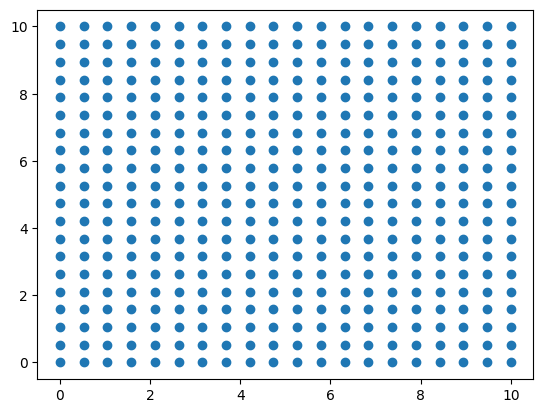

In [8]:
resolution = 20
linspace = torch.linspace(0, 10, resolution)
x, y = torch.meshgrid(linspace, linspace)
grid = torch.stack((x.flatten(), y.flatten()), dim=1)
plt.scatter(grid[:,0],grid[:,1])

None
Parameter containing:
tensor([1.], requires_grad=True)


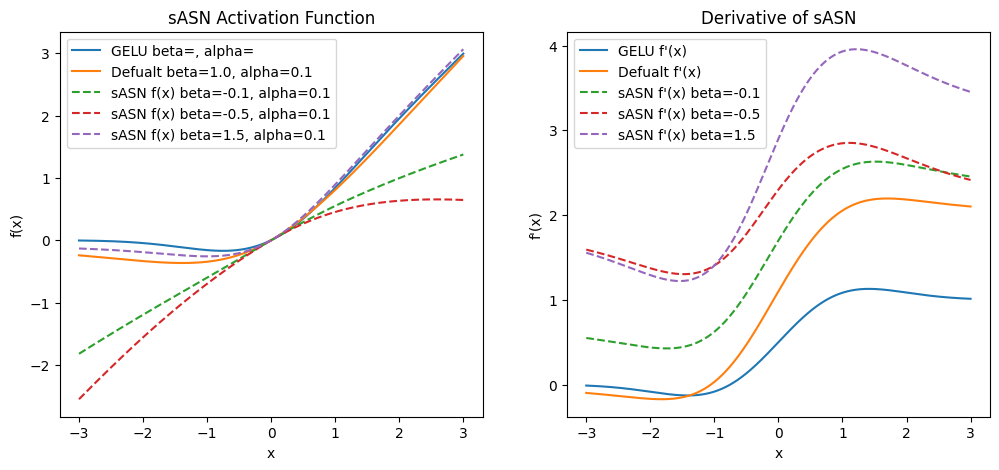

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from activation.acts import *

# Define the Swish_a activation class
class Swish_a(nn.Module):
    def __init__(self, beta_init=1.0, alpha=0.1):
        super(Swish_a, self).__init__()
        self.beta = nn.Parameter(torch.tensor(beta_init), requires_grad=False)
        self.alpha = alpha

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x) + self.alpha

# Define a function to plot the activation and its derivative
def plot_act_once(activation_instance,x,desc='Defualt'):
    y = activation_instance(x)
    y.backward(torch.ones_like(x), retain_graph=True)
    # Activation plot
    plt.subplot(1, 2, 1)
    print( getattr(activation_instance,"beta",None) )
    beta = activation_instance.beta.item() if getattr(activation_instance,"beta",None)else ""
    alpha = activation_instance.alpha if getattr(activation_instance,"alpha",None)else ""
    plt.plot(x.detach().numpy(), y.detach().numpy(), 
             label=f'{desc} beta={beta}, alpha={alpha}')
    plt.xlabel('x')
    plt.ylabel('f(x)')

    # Derivative plot
    plt.subplot(1, 2, 2)
    plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label=f"{desc} f'(x)")

def plot_swish_a_and_derivative(act_class,params=None, x_range=(-5, 5), num_points=1000):
    plt.figure(figsize=(12, 5))
    x = torch.linspace(*x_range, num_points,requires_grad=True)
    # Default function plot
    activation_class = act_class
    activation_instance = activation_class()
    plot_act_once(nn.GELU(),x,'GELU')
    plot_act_once(activation_instance,x,'Defualt')

    # Plot for each hyperparameter set in params
    if params:
        for beta, alpha in zip(params['betas'], params['alphas']):

            activation_instance = activation_class(beta_init=beta,alpha=alpha)
            y = activation_instance(x)
            y.backward(torch.ones_like(x), retain_graph=True)

            # Activation plot
            plt.subplot(1, 2, 1)
            plt.plot(x.detach().numpy(), y.detach().numpy(), linestyle='--', label=f'{act_class.__name__} f(x) beta={beta}, alpha={alpha}')
            
            # Derivative plot
            plt.subplot(1, 2, 2)
            plt.plot(x.detach().numpy(), x.grad.detach().numpy(), linestyle='--', label=f"{act_class.__name__} f'(x) beta={beta}")

    # Finalize plots
    plt.subplot(1, 2, 1)
    plt.title(f'{act_class.__name__} Activation Function')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Derivative of {act_class.__name__}')
    plt.xlabel('x')
    plt.ylabel("f'(x)")
    plt.legend()

    plt.show()

# Example parameters for multiple plots
params = {'betas': [-0.1,-0.5,1.5], 'alphas': [0.1,0.1,0.1]}
# params = {'betas': [1.,1.,1.], 'alphas': [-0.1,-0.5,0.5]}
plot_swish_a_and_derivative(act_class=sASN,params=params,x_range=(-3,3))


In [10]:
network = SimpleNN(nn.GELU())
def get_mean_weights(model):
    weights = []
    for param in model.parameters():
        weights.extend(param.data.view(-1))
    return torch.mean(torch.tensor(weights))

def get_var_weights(model):
    weights = []
    for param in model.parameters():
        weights.extend(param.data.view(-1))
    return torch.var(torch.tensor(weights))

get_mean_weights(network),get_var_weights(network)


(tensor(0.0413), tensor(0.0510))

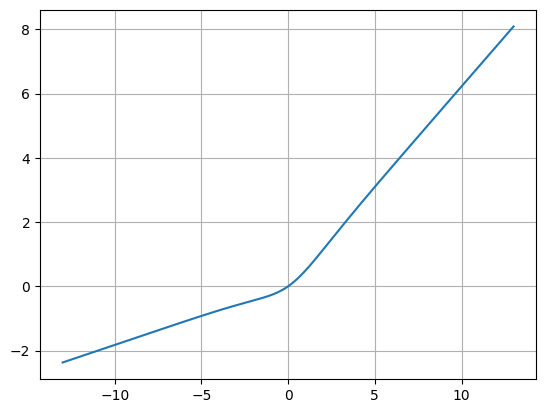

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-13, 13, 1000)

def BiPolarSquaredClip(x):
    y =  np.where(x > 0, 2*np.square(x), -2 * np.square(x))
    y_clipped = np.clip(y, -8, 8)
    return y_clipped

def sigmoid(x):
    return 1/(1+np.exp(-x))

def dd(x):
    b=0.5
    y = x*sigmoid(np.tanh(b*x)-0.5)
    
    return y

plt.plot(x,dd(x))
plt.grid()
plt.show()

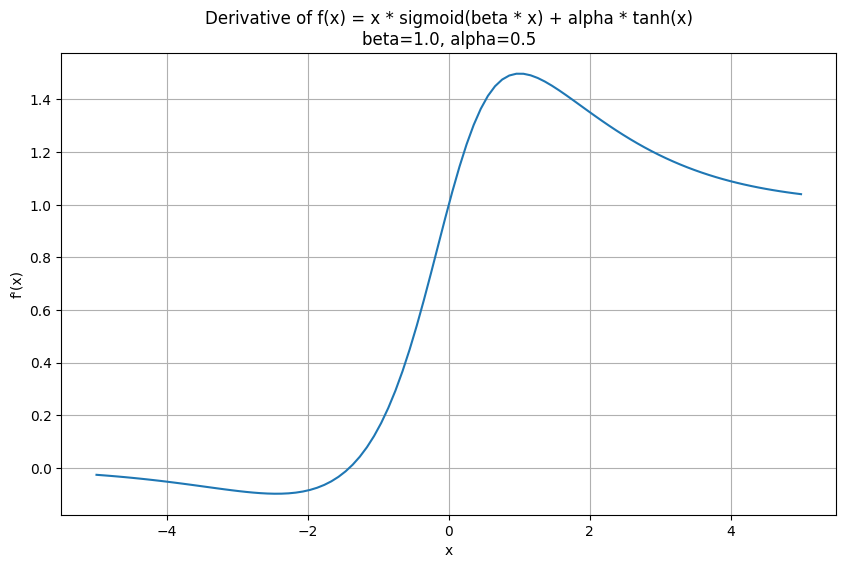

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f(x, beta, alpha):
    return x * sigmoid(beta * x) + alpha * np.tanh(x)

def df(x, beta, alpha):
    s = sigmoid(beta * x)
    t = np.tanh(x)
    exp2x = np.exp(2 * x)
    return s + beta * x * s * (1 - s) + (4 * alpha * np.exp(x)) / (exp2x + 2 + np.exp(-2 * x))

beta = 1.0
alpha = 0.5

x = np.linspace(-5, 5, 100)
y = [df(xx, beta, alpha) for xx in x]

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title(f"Derivative of f(x) = x * sigmoid(beta * x) + alpha * tanh(x)\nbeta={beta}, alpha={alpha}")
plt.xlabel("x")
plt.ylabel("f'(x)")
plt.grid()
plt.show()

Activation function Test


In [17]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
 
# Load the MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transform, download=True)
 
train_loader = DataLoader(dataset=train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=2048, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 13477004.96it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7092253.74it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 7327949.31it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9606923.23it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [18]:
import torch.nn as nn
import torch.optim as optim

 
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation_function):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, num_classes)
        self.activation_function = activation_function
 
    def forward(self, x):
        x = self.activation_function(self.layer1(x))
        x = self.activation_function(self.layer2(x))
        x = self.layer3(x)
        return x

In [19]:
def train(network, data_loader, criterion, optimizer, device):
    network.train()
    running_loss = 0.0

    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(data.shape[0], -1)

        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    return running_loss / len(data_loader.dataset)

def test(network, data_loader, criterion, device):
    network.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.shape[0], -1)

            output = network(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return test_loss / len(data_loader.dataset), 100 * correct / total

In [20]:
from time import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
input_size = 784
hidden_size = 128
num_classes = 10
num_epochs = 20
learning_rate = 0.001

activation_functions = get_activations()
results = {}

# Train and test the model with different activation functions
for name, activation_function in activation_functions.items():
    print(f"Training with {name} activation function...")

    model = NeuralNetwork(input_size, hidden_size, num_classes, activation_function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = []
    test_loss_history = []
    test_accuracy_history = []

    start_t = time()
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, test_loader, criterion, device)

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    end_t = time() - start_t
    minutes = int(end_t // 60)
    seconds = int(end_t % 60)

    results[name] = {
        'train_loss_history': train_loss_history,
        'test_loss_history': test_loss_history,
        'test_accuracy_history': test_accuracy_history,
        'train_test_time':f"{minutes}m{seconds}s"
    }

cuda
Training with sASN activation function...
Epoch [1/20], Test Loss: 0.5774, Test Accuracy: 83.81%
Epoch [2/20], Test Loss: 0.3337, Test Accuracy: 90.47%
Epoch [3/20], Test Loss: 0.2874, Test Accuracy: 91.82%
Epoch [4/20], Test Loss: 0.2639, Test Accuracy: 92.59%
Epoch [5/20], Test Loss: 0.2449, Test Accuracy: 93.13%
Epoch [6/20], Test Loss: 0.2215, Test Accuracy: 93.73%
Epoch [7/20], Test Loss: 0.2128, Test Accuracy: 93.68%
Epoch [8/20], Test Loss: 0.1880, Test Accuracy: 94.48%
Epoch [9/20], Test Loss: 0.1740, Test Accuracy: 94.81%
Epoch [10/20], Test Loss: 0.1641, Test Accuracy: 95.06%
Epoch [11/20], Test Loss: 0.1546, Test Accuracy: 95.46%
Epoch [12/20], Test Loss: 0.1455, Test Accuracy: 95.48%
Epoch [13/20], Test Loss: 0.1367, Test Accuracy: 95.89%
Epoch [14/20], Test Loss: 0.1280, Test Accuracy: 96.14%
Epoch [15/20], Test Loss: 0.1253, Test Accuracy: 96.18%
Epoch [16/20], Test Loss: 0.1207, Test Accuracy: 96.20%
Epoch [17/20], Test Loss: 0.1133, Test Accuracy: 96.54%
Epoch [18/

In [28]:
max(data['test_accuracy_history'])

97.63

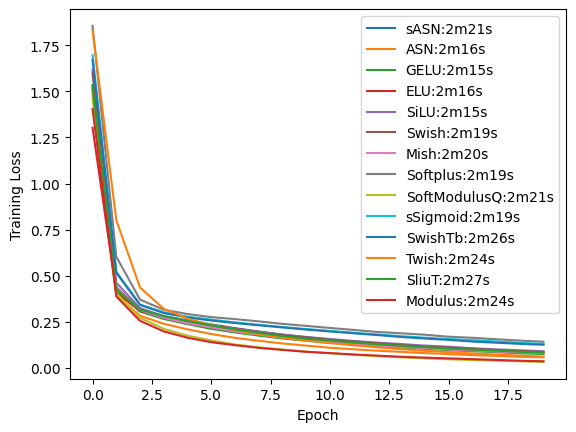

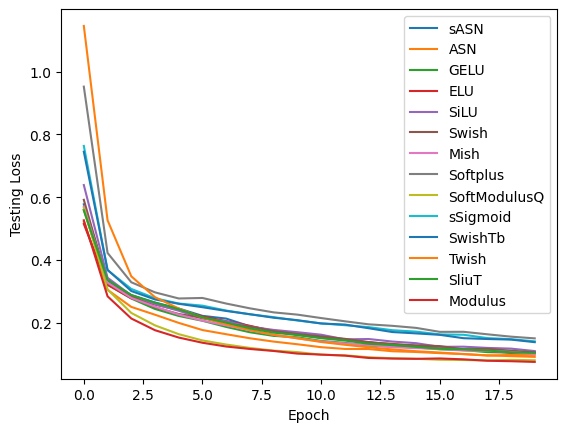

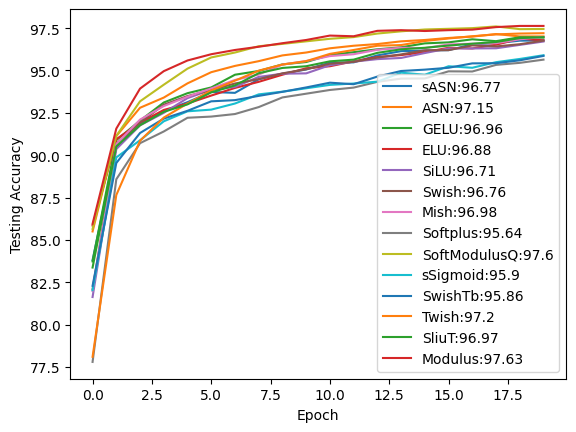

In [29]:
import matplotlib.pyplot as plt
import os
# Plot the training loss
os.makedirs('Activation',exist_ok=True)
plt.figure()
for name, data in results.items():
    plt.plot(data['train_loss_history'], label=f"{name}:{data['train_test_time']}")
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig(f'./Activation/train_loss_{"_".join(results.keys())}.png')
plt.show()
 
# Plot the testing loss
plt.figure()
for name, data in results.items():
    plt.plot(data['test_loss_history'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.legend()
plt.savefig(f'./Activation/test_loss_{"_".join(results.keys())}.png')
plt.show()
 
# Plot the testing accuracy
plt.figure()
for name, data in results.items():
    plt.plot(data['test_accuracy_history'], label=f"{name}:{max(data['test_accuracy_history'])}")
plt.xlabel('Epoch')
plt.ylabel('Testing Accuracy')
plt.legend()
plt.savefig(f'./Activation/test_acc_{"_".join(results.keys())}.png')
plt.show()

In [32]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

class NoisyDataset(Dataset):
    def __init__(self, dataset, noise_level=0, max_noise_level=1):
        self.dataset = dataset
        self.noise_level = noise_level
        self.max_noise_level = max_noise_level

    def __getitem__(self, index):
        image, label = self.dataset[index]
        # Scale the noise level from 0 (no noise) to max_noise_level (max noise)
        current_std_dev = (self.noise_level / self.max_noise_level) * 1.0
        noise = torch.randn_like(image) * current_std_dev
        noisy_image = image + noise
        return noisy_image, label

    def __len__(self):
        return len(self.dataset)

    def set_noise_level(self, noise_level):
        self.noise_level = noise_level

# Example of usage:
transform = transforms.ToTensor()
test_dataset = MNIST(root='data/', train=False, transform=transform, download=False)
test_loader = DataLoader(dataset=NoisyDataset(test_dataset), batch_size=2048, shuffle=False)

# Function to evaluate the model at different noise levels
def evaluate_model_with_noise(model, data_loader, device, max_noise_level=5):
    model.eval()
    model.to(device)
    
    noise_levels = range(1, max_noise_level + 1)
    performances = []

    for level in noise_levels:
        correct = 0
        total = 0
        data_loader.dataset.set_noise_level(level)

        test_loss, test_accuracy = test(model, data_loader, criterion, device)

        performances.append(test_accuracy)
        print(f"Noise Level {level}/{max_noise_level}: Accuracy = {test_accuracy:.2f}%")

    return performances

# Example of calling the evaluation function with a PyTorch model
# You would need to replace 'my_model' and 'my_device' with your actual model and device.
evaluate_model_with_noise(model, test_loader, torch.device('cuda:0'))


Noise Level 1/10: Accuracy = 41.32%
Noise Level 2/10: Accuracy = 19.03%
Noise Level 3/10: Accuracy = 14.01%
Noise Level 4/10: Accuracy = 12.33%
Noise Level 5/10: Accuracy = 11.78%
Noise Level 6/10: Accuracy = 11.60%
Noise Level 7/10: Accuracy = 11.05%
Noise Level 8/10: Accuracy = 11.05%
Noise Level 9/10: Accuracy = 10.62%
Noise Level 10/10: Accuracy = 9.84%


[41.32, 19.03, 14.01, 12.33, 11.78, 11.6, 11.05, 11.05, 10.62, 9.84]

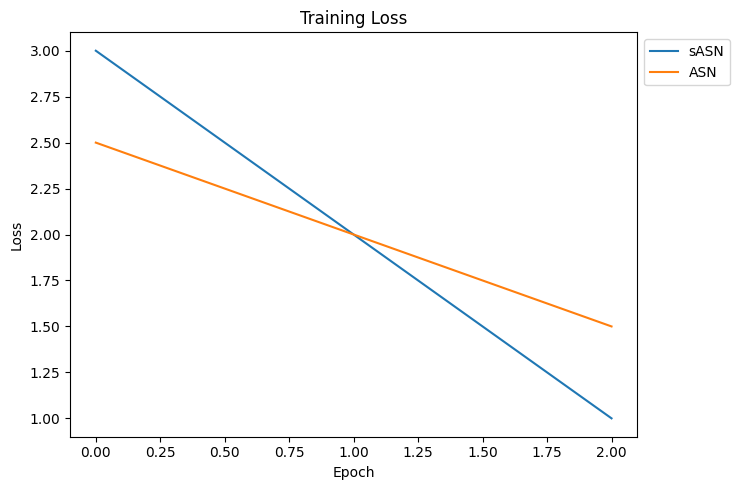

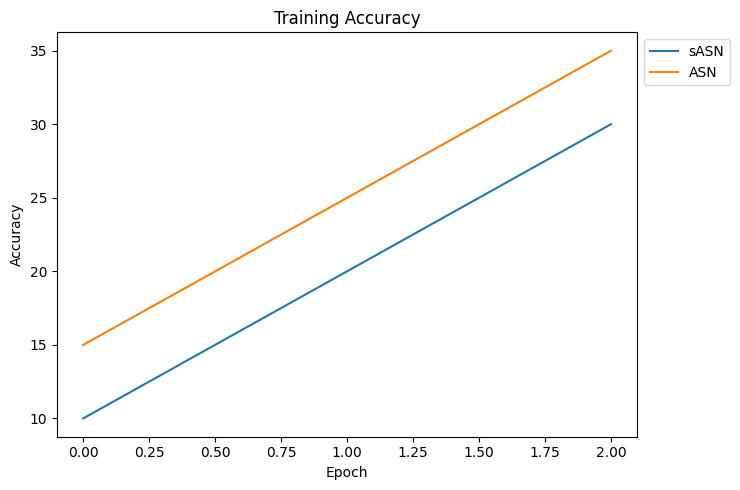

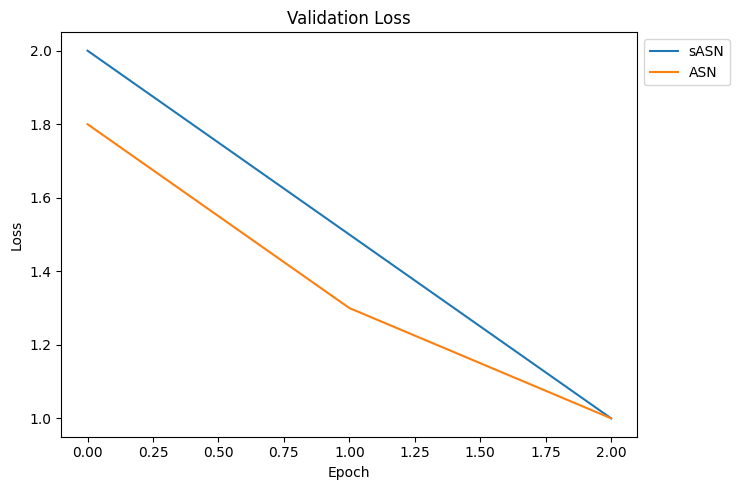

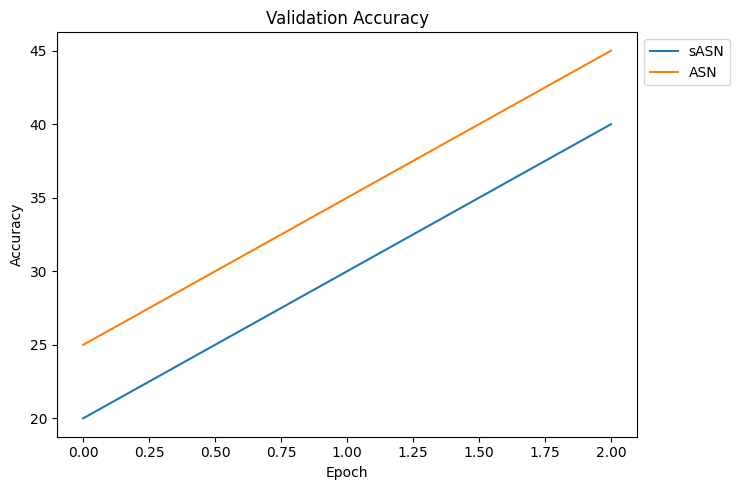

In [33]:
import os
import matplotlib.pyplot as plt

def plot_and_save_results(results, save_dir='results'):
    # Create a directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Initialize subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # 조정된 크기
    axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

    # Plot each metric for all activation functions on their respective subplot
    for act_name, metrics in results.items():
        # Plot training loss
        axes[0].plot(metrics['train_loss'], label=f'{act_name}')
        axes[0].set_title('Training Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')

        # Plot training accuracy
        axes[1].plot(metrics['train_acc'], label=f'{act_name}')
        axes[1].set_title('Training Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')

        # Plot validation loss
        axes[2].plot(metrics['val_loss'], label=f'{act_name}')
        axes[2].set_title('Validation Loss')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Loss')

        # Plot validation accuracy
        axes[3].plot(metrics['val_acc'], label=f'{act_name}')
        axes[3].set_title('Validation Accuracy')
        axes[3].set_xlabel('Epoch')
        axes[3].set_ylabel('Accuracy')

    # Adjust layout to prevent overlap and make room for the legend
    fig.tight_layout()
    fig.subplots_adjust(right=0.8)  # 여백 조정

    # Add legends to the right of the subplots
    for ax in axes:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Save the combined plot
    plt.savefig(os.path.join(save_dir, 'combined_metrics.png'), bbox_inches='tight')

    # Close the figure to free up memory
    plt.close(fig)

# Usage example, assuming 'comp_dict' is a dictionary containing your metrics
# plot_and_save_results(comp_dict)
